In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

imagepath = os.path.join(os.getcwd(), "ion_data", "Входные данные")

# 1. Ion mean position and size determination

In [3]:
max_inp = np.zeros((164, 56)).astype("float16")
all_hist = np.zeros(256)

THRESHOLD = 15

for item in os.listdir(imagepath):
    if ".png" not in item:
        continue
    path = os.path.join(imagepath, item)
    inp = np.array(cv2.imread(path, 2)).astype("uint8")

    for i in range(inp.shape[0]):
        for j in range(inp.shape[1]):
            all_hist[inp[i, j]] += 1

    thresh_value, threshed_inp = cv2.threshold(inp, THRESHOLD, 255, cv2.THRESH_TOZERO)

    max_inp += threshed_inp / 1000

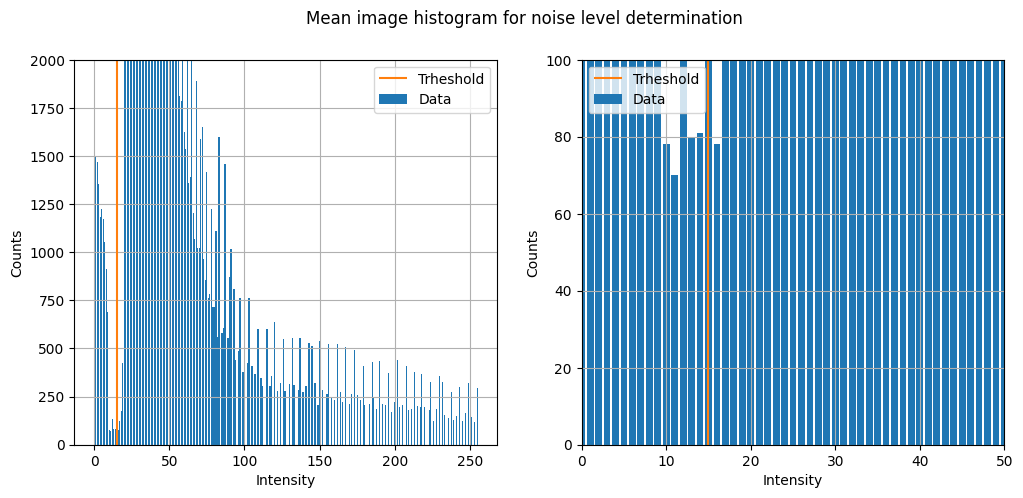

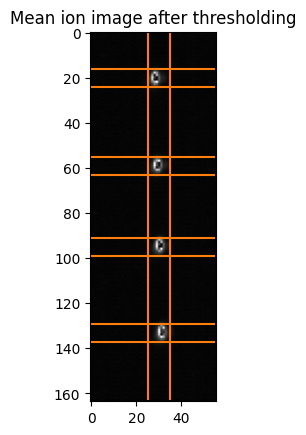

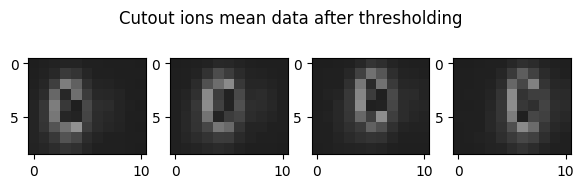

In [4]:
# define half-widths and ions target positions
hwx = 5
hwy = 4
centers_x = [30]
centers_y = [20, 59, 95, 133]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
ax1.bar(range(len(all_hist)), all_hist, label="Data")
ax1.vlines(THRESHOLD, 0, 2000, color="C1", label="Trheshold")
ax1.set_ylim((0, 2000))
ax1.set_xlabel("Intensity")
ax1.set_ylabel("Counts")
ax1.grid()
ax1.legend()

ax2.bar(range(len(all_hist)), all_hist, label="Data")
ax2.vlines(THRESHOLD, 0, 100, color="C1", label="Trheshold")
ax2.set_ylim((0, 100))
ax2.set_xlim((0, 50))
ax2.grid()
ax2.set_xlabel("Intensity")
ax2.set_ylabel("Counts")
ax2.legend()
plt.suptitle("Mean image histogram for noise level determination")
plt.show()


fig = plt.figure()
plt.imshow(max_inp, cmap="gray")
plt.vlines([centers_x[0] - hwx, centers_x[0] + hwx], 0, 163, color="C1")
for cy in centers_y:
    plt.hlines([cy - hwy, cy + hwy], 0, 55, color="C1")
plt.title("Mean ion image after thresholding")
plt.show()


fig, axes = plt.subplots(1, 4, figsize=(7, 2))
for i, cy in enumerate(centers_y):
    axes[i].imshow(max_inp[cy - hwy:cy + hwy + 1, centers_x[0] - hwx: centers_x[0] + hwx + 1], cmap="gray", vmin=0, vmax=255)
plt.suptitle("Cutout ions mean data after thresholding")
plt.show()

# Integral threshold determination

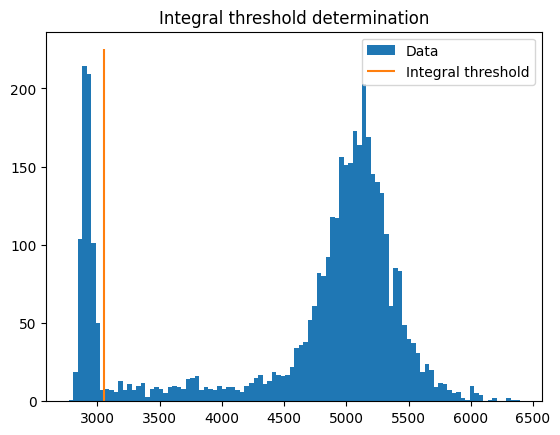

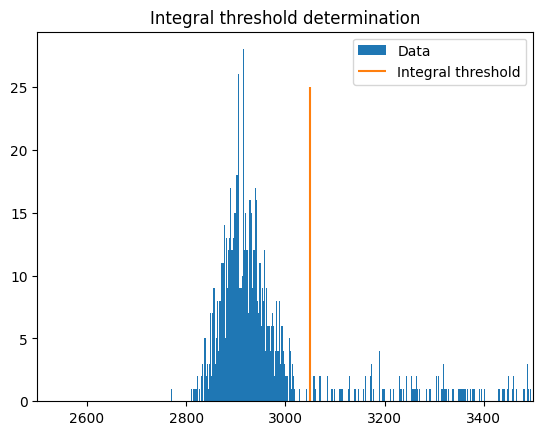

In [5]:
intensities = []

for item in os.listdir(imagepath):
    if ".png" not in item:
        continue
    path = os.path.join(imagepath, item)
    inp = np.array(cv2.imread(path, 2)).astype("uint8")

    thresh_value, threshed_inp = cv2.threshold(inp, THRESHOLD, 255, cv2.THRESH_TOZERO)
    for ind, cy in enumerate(centers_y):
        int = np.sum(threshed_inp.T[centers_x[0] - hwx: centers_x[0] + hwx + 1, cy - hwy: cy + hwy + 1])
        intensities.append(int)

INTEGRAL_THRESHOLD = 3050

plt.figure()
ns, bins, _ = plt.hist(intensities, bins=100, label="Data")
plt.vlines(INTEGRAL_THRESHOLD, 0, 225, color="C1", label="Integral threshold")
plt.title("Integral threshold determination")
plt.legend()
plt.show()

plt.figure()
ns, bins, _ = plt.hist(intensities, bins=1600, label="Data")
plt.xlim((2500, 3500))
plt.vlines(INTEGRAL_THRESHOLD, 0, 25, color="C1", label="Integral threshold")
plt.title("Integral threshold determination")
plt.legend()
plt.show()

# 3. Image labeling

In [6]:
savepath = os.path.join(os.getcwd(), "ion_data", "Выходные данные")
cut_savepath = os.path.join(os.getcwd(), "ion_data", "cut_images")

intensities = []
for item_ind, item in enumerate(os.listdir(imagepath)):
    if ".png" not in item:
        continue
    path = os.path.join(imagepath, item)
    inp = np.array(cv2.imread(path, 2)).astype("uint8")

    thresh_value, threshed_inp = cv2.threshold(inp, THRESHOLD, 255, cv2.THRESH_TOZERO)

    label = [0, 0, 0, 0]
    for ind, cy in enumerate(centers_y):
        int = np.sum(threshed_inp.T[centers_x[0] - hwx: centers_x[0] + hwx + 1, cy - hwy: cy + hwy + 1])
        intensities.append(int)
        if int >= INTEGRAL_THRESHOLD:
            label[ind] = 1
        cv2.imwrite(
            os.path.join(
                cut_savepath, f"{item_ind}_{ind}_{label[ind]}.png"
            ),
            inp.T[centers_x[0] - hwx: centers_x[0] + hwx + 1, cy - hwy: cy + hwy + 1]
        )

    cut_filepath = os.path.join(savepath, f"{item_ind}_{''.join(map(str, label))}.png")
    cv2.imwrite(cut_filepath, inp) 